In [1]:
import json, requests, time, pandas as pd
from string import Template

In [2]:
WIKIDATA_ENDPOINT = 'https://query.wikidata.org/sparql'

QUERY_HEADERS = {
    'User-Agent': 'ConceptualEngineeringBot/0.1 (https://github.com/bradleypallen/conceptual-engineering-using-llms; bradley.p.allen@gmail.com)'
}

CLASS_QUERY = """SELECT ?class ?classLabel ?classDescription ?classWikipediaName ?classArticle ?superclass ?superclassLabel ?superclassDescription ?superclassWikipediaName ?superclassArticle WHERE {
    ?class wdt:P279 ?superclass ;
              rdfs:label ?classLabel ;
              schema:description ?classDescription .
    ?superclass rdfs:label ?superclassLabel ;
              schema:description ?superclassDescription .
    ?classArticle schema:about ?class ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?classWikipediaName .
    ?superclassArticle schema:about ?superclass ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?superclassWikipediaName .
    FILTER(LANG(?classLabel) = "en")
    FILTER(LANG(?classDescription) = "en")
    FILTER(LANG(?superclassLabel) = "en")
    FILTER(LANG(?superclassDescription) = "en")
}
LIMIT 15000
"""

CLASS_EXTENSION_CARDINALITY_QUERY = Template("""SELECT (COUNT(?instance) AS ?count) WHERE {
    ?instance p:P31/ps:P31/wdt:P279* $class .
}
""")
                                             
MIN_CARDINALITY = 100

In [3]:
def extension_cardinality(wd_class):
    time.sleep(0.250)
    response = requests.get(WIKIDATA_ENDPOINT, params={'query' : CLASS_EXTENSION_CARDINALITY_QUERY.substitute({"class": wd_class}), 'format' : 'json'}, headers=QUERY_HEADERS)
    response.raise_for_status()
    return int(json.loads(response.text)["results"]["bindings"][0]["count"]["value"])

In [4]:
print("Getting classes...")
response = requests.get(WIKIDATA_ENDPOINT, params={'query' : CLASS_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
candidates = []
classes = [ { k: v["value"] for k, v in result.items() } for result in json.loads(response.text)["results"]["bindings"] ]
print("Getting extension cardinalities...", end = " ")
for i, cls in enumerate(classes):
    count = extension_cardinality(f'wd:{cls["class"].removeprefix("http://www.wikidata.org/entity/")}')
    if count >= MIN_CARDINALITY:
        cls["count"] = count
        candidates.append(cls)
    if i > 0 and i % 1000 == 0:
        print(f'{i}... ', end = " ")
print(f'Found {len(candidates)} classes with extension cardinality >= {MIN_CARDINALITY}.')

Getting classes...
Getting extension cardinalities... 

In [ ]:
json.dump(candidates, open('benchmarks/candidates.json', 'w+'))

In [ ]:
df = pd.DataFrame.from_records(candidates).sort_values("count", ascending=False)
df_range = df[["classLabel", "classDescription", "count", "superclassLabel"]]
df_range.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})

NameError: name 'candidates' is not defined

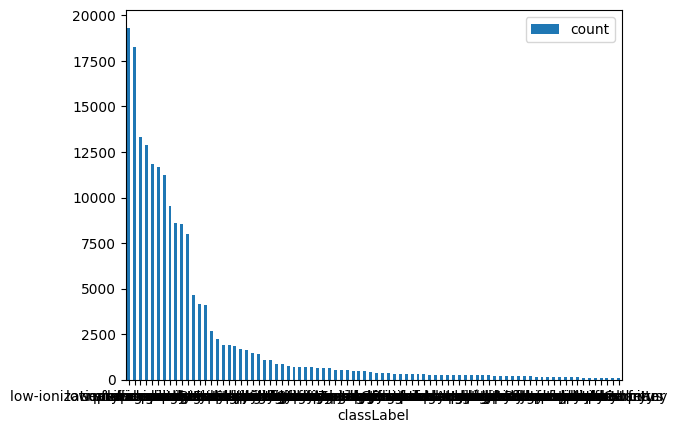

In [ ]:
ax = df_range.plot.bar(x='classLabel', y='count', rot=0)

In [ ]:
len(df)

94

In [ ]:
df[df["classLabel"] == 'red wine']

,class,superclass,classArticle,superclassArticle,classWikipediaName,superclassWikipediaName,classLabel,superclassLabel,classDescription,superclassDescription,count
15,http://www.wikidata.org/entity/Q1827,http://www.wikidata.org/entity/Q282,https://en.wikipedia.org/wiki/Red_wine,https://en.wikipedia.org/wiki/Wine,Red wine,Wine,red wine,wine,wine made from dark-colored grape varieties wi...,alcoholic drink typically made from grapes thr...,367


In [ ]:
import wikipedia
red_wine_summary = wikipedia.summary('Red wine', auto_suggest=False)

In [ ]:
red_wine_summary

'Red wine is a type of wine made from dark-colored grape varieties. The color of the wine can range from intense violet, typical of young wines, through to brick red for mature wines and brown for older red wines. The juice from most purple grapes is greenish-white, the red color coming from anthocyan pigments present in the skin of the grape. Much of the red wine production process involves extraction of color and flavor components from the grape skin.'